<a href="https://colab.research.google.com/github/lucabarattini/transformer-is-all-you-need/blob/main/Copy_of_Luca_Barattini_LB3656_Applied_Machine_Learning_HW3_3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COMSW4995 - Applied Machine Learning - HW3:
### Luca Barattini - @lb3656:


---


## Data Preparation:  


---


##Importing our libraries:


In [1]:
# ===================================================================
# 0. IMPORTS & SETUP
# ===================================================================
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tokenizers import Tokenizer, models, trainers, pre_tokenizers
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import re
import random

In [2]:
# ===================================================================
# 0b. GLOBAL CONFIG & SEEDING
# ===================================================================
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda




---

## Data Loading and tokenization:

In [3]:
# ===================================================================
# 1a. LOADING RAW TEXT
# ===================================================================
text_path = "input.txt"
with open(text_path, "r", encoding="utf-8") as f:
    text = f.read()

# ===================================================================
# 1b. INITIAL DATA INSPECTION
# ===================================================================
len_in_mm = len(text)/1_000_000
print(f"Length of dataset in characters: {len_in_mm:.1f} MM")
print("-----------------------------")
print("\n--- First 1000 characters ---")
print(text[:1000])
print("-----------------------------")

# ===================================================================
# 1c. TOKENIZER TRAINING
# ===================================================================
print("--- Training Tokenizer (vocab_size=500) ---")
tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
trainer = trainers.BpeTrainer(vocab_size=500, special_tokens=["[PAD]", "[UNK]"])
tokenizer.train_from_iterator([text], trainer=trainer)
vocab_size = tokenizer.get_vocab_size()
print(f"Tokenizer trained. Vocab size: {vocab_size}")

# ===================================================================
# 1d. ENCODING TEXT TO TENSORS
# ===================================================================
encoded = tokenizer.encode(text)
ids = torch.tensor(encoded.ids, dtype=torch.long)
print(f"Total tokens in dataset: {len(ids):,}")

Length of dataset in characters: 1.1 MM
-----------------------------

--- First 1000 characters ---
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, 



---

## Data and Tokenizer Sanity Check:


--- 1. Basic Text Stats ---
Total characters in text: 1,115,394
Total unique characters: 65

--- 2. Tokenizer Sanity Check (Top 20 Tokens) ---
Top 20 most common tokens (data for chart):
{',': 19846, 's': 11828, ':': 10316, '.': 7885, 'I': 6699, 'd': 6224, "'": 6187, 't': 5916, 'a': 5567, 'the': 5540, 'to': 4688, 'p': 4598, 'c': 4516, 'in': 4238, 'and': 4179, 'e': 4117, 'er': 3800, ';': 3628, 'of': 3617, 'be': 3568}


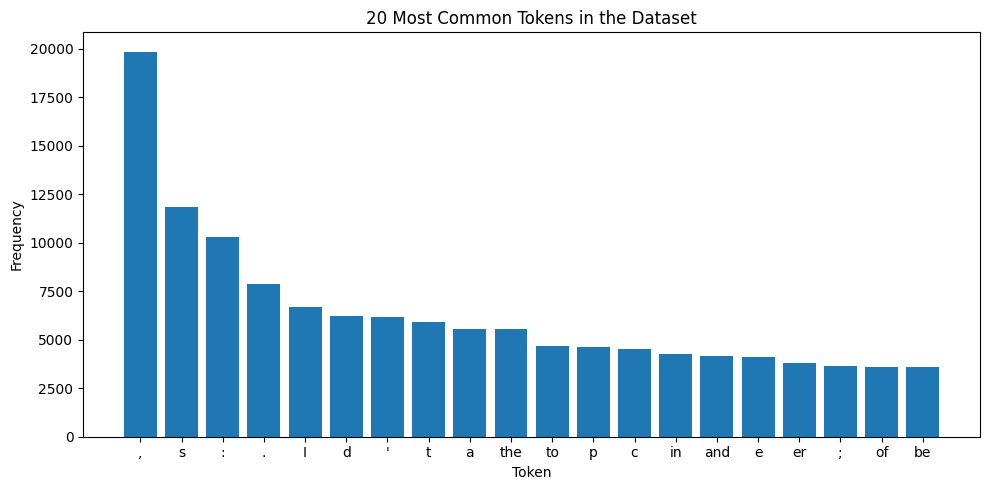


--- 3. Classical vs. BPE Vocab Analysis ---
Top 100 most frequent 'classical' words found:
[(',', 19602), (':', 10274), ('.', 7811), ('the', 6287), ("'", 5924), ('and', 5690), ('i', 5111), ('to', 4934), ('of', 3760), (';', 3598), ('you', 3211), ('my', 3120), ('a', 3018), ('that', 2664), ('?', 2419), ('in', 2403), ('is', 2118), ('!', 2105), ('not', 2015), ('for', 1926), ('s', 1859), ('with', 1813), ('it', 1773), ('me', 1769), ('be', 1710), ('your', 1686), ('he', 1606), ('his', 1552), ('this', 1509), ('but', 1507), ('have', 1450), ('d', 1445), ('thou', 1421), ('as', 1420), ('what', 1211), ('him', 1209), ('so', 1177), ('thy', 1059), ('will', 1053), ('-', 1005), ('we', 938), ('king', 925), ('by', 911), ('all', 910), ('no', 906), ('shall', 849), ('her', 829), ('if', 807), ('do', 799), ('our', 786), ('are', 785), ('thee', 762), ('o', 751), ('lord', 711), ('on', 701), ('now', 701), ('good', 672), ('come', 624), ('from', 624), ('sir', 597), ('or', 592), ('which', 587), ('more', 582), ('ll', 5

In [4]:
# ===================================================================
# 2a. BASIC TEXT STATS
# ===================================================================
print("\n--- 1. Basic Text Stats ---")
chars = sorted(list(set(text)))
vocab_size_chars = len(chars)
print(f"Total characters in text: {len(text):,}")
print(f"Total unique characters: {vocab_size_chars}")

# ===================================================================
# 2b. TOKENIZER SANITY CHECK (TOP 20 TOKENS)
# ===================================================================
print("\n--- 2. Tokenizer Sanity Check (Top 20 Tokens) ---")
token_counts = Counter(encoded.ids)
most_common_tokens = token_counts.most_common(20)
token_ids = [token[0] for token in most_common_tokens]
token_names = [tokenizer.id_to_token(tid) for tid in token_ids]
token_freq = [token[1] for token in most_common_tokens]
print("Top 20 most common tokens (data for chart):")
print(dict(zip(token_names, token_freq)))

# ===================================================================
# 2c. PLOT TOKEN FREQUENCY
# ===================================================================
plt.figure(figsize=(10, 5))
plt.bar(token_names, token_freq)
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.title("20 Most Common Tokens in the Dataset")
plt.xticks(rotation='horizontal')
plt.tight_layout()
plt.show()

# ===================================================================
# 2d. CLASSICAL VS. BPE VOCAB ANALYSIS
# ===================================================================
print("\n--- 3. Classical vs. BPE Vocab Analysis ---")
pre_tokenized_list = tokenizer.pre_tokenizer.pre_tokenize_str(text)
classical_words = [word.lower() for word, offset in pre_tokenized_list]
word_counts = Counter(classical_words)
top_100_classical_words = word_counts.most_common(100)

print("Top 100 most frequent 'classical' words found:")
print(top_100_classical_words)
print("--------------------------------------")

bpe_vocab_dict = tokenizer.get_vocab()
bpe_vocab_set = set(bpe_vocab_dict.keys())
print(f"Total BPE vocab size: {len(bpe_vocab_set)} (includes letters, subwords, etc.)")

top_100_word_set = set([word for word, count in top_100_classical_words])
missed_words = top_100_word_set.difference(bpe_vocab_set)
captured_words = top_100_word_set.intersection(bpe_vocab_set)

print(f"Words in Top 100 that BPE *captured* as single tokens: \n{captured_words}")
print(f"\nWords in Top 100 that BPE *missed* (and must build from pieces): \n{missed_words}")



---

## Model and Function Definition:

In [5]:
# ===================================================================
# 3a. DATASET CLASS DEFINITION
# ===================================================================
class ShakespeareDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# ===================================================================
# 3b. RMSNORM LAYER DEFINITION
# ===================================================================
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-8):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def forward(self, x):
        norm = x.pow(2).mean(-1, keepdim=True)
        return x * torch.rsqrt(norm + self.eps) * self.weight

# ===================================================================
# 3c. MULTI-HEAD SELF-ATTENTION DEFINITION
# ===================================================================
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.qkv_proj = nn.Linear(d_model, 3 * d_model, bias=False)
        self.out_proj = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x, causal_mask=None):
        batch_size, seq_len, _ = x.shape

        qkv = self.qkv_proj(x)
        qkv = qkv.reshape(batch_size, seq_len, 3, self.n_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        Q, K, V = qkv[0], qkv[1], qkv[2]

        scores = (Q @ K.transpose(-2, -1)) / math.sqrt(self.head_dim)

        if causal_mask is not None:
            mask_expanded = causal_mask.unsqueeze(0).unsqueeze(0)
            scores = scores.masked_fill(mask_expanded == 0, float("-inf"))

        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = torch.nan_to_num(attn_weights, 0.0)

        out = (attn_weights @ V).transpose(1, 2).reshape(batch_size, seq_len, self.d_model)
        out = self.out_proj(out)

        return out, attn_weights

# ===================================================================
# 3d. TRANSFORMER BLOCK DEFINITION
# ===================================================================
class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, seq_len):
        super().__init__()
        self.attn = MultiHeadSelfAttention(d_model, n_heads)
        self.norm1 = RMSNorm(d_model)
        self.norm2 = RMSNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Linear(d_ff, d_model),
        )
        mask = torch.tril(torch.ones(seq_len, seq_len))
        self.register_buffer("causal_mask", mask)

    def forward(self, x, return_attn=False):
        seq_len = x.size(1)
        causal_mask = self.causal_mask[:seq_len, :seq_len].to(x.device)

        h = self.norm1(x)
        attn_out, attn_weights = self.attn(h, causal_mask)
        x = x + attn_out

        h = self.norm2(x)
        ff_out = self.ff(h)
        x = x + ff_out

        if return_attn:
            return x, attn_weights
        return x, None

# ===================================================================
# 3e. FULL TRANSFORMER MODEL DEFINITION
# ===================================================================
class TinyTransformerLM(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, d_ff, max_seq_len, n_layers):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)

        pos = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_seq_len, d_model)
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        self.register_buffer("pos_encoding", pe.unsqueeze(0))

        self.layers = nn.ModuleList(
            [TransformerBlock(d_model, n_heads, d_ff, max_seq_len) for _ in range(n_layers)]
        )
        self.norm = RMSNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, x, return_attn=False):
        bsz, seq_len = x.size()

        pos_encoding = self.pos_encoding[:, :seq_len, :].to(x.device)
        tok = self.token_embedding(x)
        h = tok + pos_encoding

        attn_maps = []
        for layer in self.layers:
            h, attn = layer(h, return_attn=return_attn)
            if return_attn:
                attn_maps.append(attn)

        h = self.norm(h)
        logits = self.head(h)

        if return_attn:
            return logits, attn_maps
        return logits

# ===================================================================
# 3f. INFERENCE & PLOTTING FUNCTIONS
# ===================================================================
def clean_generated(text):
    text = re.sub(r"\s+([.,!?;:])", r"\1", text)
    text = re.sub(r"\(\s+", "(", text)
    text = re.sub(r"\s+\)", ")", text)
    text = re.sub(r"\s+'", "'", text)
    text = re.sub(r"'\s+", "'", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def generate_text(model, tokenizer, device, prompt, max_new_tokens=50, temperature=0.9, seq_len=128):
    model.eval()
    with torch.no_grad():
        encoded = tokenizer.encode(prompt)
        prompt_ids = encoded.ids
        ids = torch.tensor(prompt_ids, dtype=torch.long, device=device).unsqueeze(0)
        for _ in range(max_new_tokens):
            if ids.size(1) > seq_len:
                ids_cond = ids[:, -seq_len:]
            else:
                ids_cond = ids
            logits = model(ids_cond)
            next_token_logits = logits[0, -1] / temperature
            probs = torch.softmax(next_token_logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)
            ids = torch.cat([ids, next_id.unsqueeze(0)], dim=1)

        out_ids = ids[0].cpu().tolist()
        text = tokenizer.decode(out_ids)
        return clean_generated(text)

def predict_next_tokens(model, tokenizer, device, prompt, top_k=5, seq_len=128):
    model.eval()
    with torch.no_grad():
        encoded = tokenizer.encode(prompt)
        ids = torch.tensor(encoded.ids, dtype=torch.long, device=device).unsqueeze(0)
        if ids.size(1) > seq_len:
            ids = ids[:, -seq_len:]
        logits = model(ids)
        next_logits = logits[0, -1]
        probs = torch.softmax(next_logits, dim=-1)
        top_probs, top_idx = torch.topk(probs, min(top_k, vocab_size))
        tokens = [tokenizer.id_to_token(i.item()) for i in top_idx]
        return list(zip(tokens, top_probs.cpu().tolist()))

def show_attention_heatmap(model, tokenizer, data_loader, device, layer=0, head=0):
    model.eval()
    with torch.no_grad():
        x, y = next(iter(data_loader))
        x = x[:1].to(device)
        logits, attn_maps = model(x, return_attn=True)

    attn = attn_maps[layer][0, head].cpu().numpy()

    ids = x[0].cpu().tolist()
    tokens = [tokenizer.id_to_token(i) for i in ids]

    plt.figure(figsize=(10, 10))
    im = plt.imshow(attn, aspect="auto", origin="lower")
    plt.xticks(range(len(tokens)), tokens, rotation=45)
    plt.yticks(range(len(tokens)), tokens)
    plt.title(f"Layer {layer}, Head {head} Attention")
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label("Attention weight")
    plt.tight_layout()
    plt.show()



---

## Hyperparameter and experiment setup:

In [6]:
# ===================================================================
# 4. HYPERPARAMETER EXPERIMENT SETUP
# ===================================================================
all_results = []
max_epochs = 20

experiments = [
    {
        "name": "Baseline_seq64_d128_lr3e-4_bs512",
        "seq_len": 64,
        "d_model": 128,
        "n_layers": 2,
        "n_heads": 4,
        "d_ff": 256,
        "lr": 3e-4,
        "batch_size": 512,
        "num_epochs": max_epochs,
        "early_stop_patience": 1,
    },
    {
        "name": "MediumContext_seq128_d128_lr3e-4_bs512",
        "seq_len": 128,
        "d_model": 128,
        "n_layers": 2,
        "n_heads": 4,
        "d_ff": 256,
        "lr": 3e-4,
        "batch_size": 512,
        "num_epochs": max_epochs,
        "early_stop_patience": 1,
    },
    {
        "name": "WiderModel_seq64_d256_lr1e-4_bs512",
        "seq_len": 64,
        "d_model": 256,
        "n_layers": 2,
        "n_heads": 8,
        "d_ff": 512,
        "lr": 1e-4,
        "batch_size": 512,
        "num_epochs": max_epochs,
        "early_stop_patience": 1,
    },
]



---

## Main model training:

In [7]:
# ===================================================================
# 5. EXPERIMENT LOOP
# ===================================================================

for config in experiments:

    print("\n" + "="*80)
    print(f"STARTING EXPERIMENT: {config['name']}")
    print(config)
    print("="*80)

    # ===================================================================
    # 5a. DATA PREPARATION (PER-EXPERIMENT)
    # ===================================================================
    seq_len = config["seq_len"]
    batch_size = config["batch_size"]

    num_sequences = len(ids) - seq_len
    inputs = torch.stack([ids[i:i+seq_len] for i in range(num_sequences)])
    targets = torch.stack([ids[i+1:i+seq_len+1] for i in range(num_sequences)])

    split_idx = int(0.8 * len(inputs))
    train_inputs = inputs[:split_idx]
    val_inputs = inputs[split_idx:]
    train_targets = targets[:split_idx]
    val_targets = targets[split_idx:]

    print(f"Data split: {len(train_inputs):,} training samples, {len(val_inputs):,} validation samples (80/20 split)")

    train_dataset = ShakespeareDataset(train_inputs, train_targets)
    val_dataset = ShakespeareDataset(val_inputs, val_targets)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    print(f"Data prepared: seq_len={seq_len}, batch_size={batch_size}")

    # ===================================================================
    # 5b. MODEL & TRAINING INITIALIZATION (PER-EXPERIMENT)
    # ===================================================================
    d_model = config["d_model"]
    n_heads = config["n_heads"]
    d_ff = config["d_ff"]
    n_layers = config["n_layers"]

    model = TinyTransformerLM(
        vocab_size=vocab_size,
        d_model=d_model,
        n_heads=n_heads,
        d_ff=d_ff,
        max_seq_len=seq_len,
        n_layers=n_layers,
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=1
    )
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

    train_losses = []
    val_losses = []
    val_ppls = []

    best_val_ppl = float('inf')
    best_model_state = None
    epochs_without_improvement = 0
    early_stop_patience = config.get("early_stop_patience", 1)

    print(f"Model initialized. Parameters: {sum(p.numel() for p in model.parameters()):,}")

    # ===================================================================
    # 5c. MODEL TRAINING LOOP (PER-EXPERIMENT)
    # ===================================================================
    for epoch in range(1, config["num_epochs"] + 1):

        model.train()
        total_train_loss = 0.0
        total_tokens = 0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                logits = model(x)
                loss = criterion(logits.view(-1, vocab_size), y.view(-1))

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            total_train_loss += loss.item() * x.numel()
            total_tokens += x.numel()

        avg_train_loss = total_train_loss / total_tokens
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0.0
        total_val_tokens = 0
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)
                with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                    logits = model(x)
                    logits_flat = logits.view(-1, vocab_size)
                    y_flat = y.view(-1)
                    loss = criterion(logits_flat, y_flat)

                total_val_loss += loss.item() * x.numel()
                total_val_tokens += x.numel()

        avg_val_loss = total_val_loss / total_val_tokens
        val_losses.append(avg_val_loss)
        val_ppl = math.exp(avg_val_loss)
        val_ppls.append(val_ppl)

        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch}/{config['num_epochs']}: train_loss={avg_train_loss:.4f}, val_loss={avg_val_loss:.4f}, val_ppl={val_ppl:.2f}")

        if val_ppl < best_val_ppl:
            best_val_ppl = val_ppl
            best_model_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            epochs_without_improvement = 0
            print(f"  ^ New best model saved at epoch {epoch}!")
        else:
            epochs_without_improvement += 1
            print(f"  No improvement in PPL for {epochs_without_improvement} epoch(s).")
            if epochs_without_improvement >= early_stop_patience:
                print(f"  Early stopping triggered after {epochs_without_improvement} epoch(s) without improvement.")
                break

    # ===================================================================
    # 5d. STORE RESULTS FOR THIS EXPERIMENT
    # ===================================================================
    all_results.append({
        "name": config["name"],
        "config": config,
        "best_ppl": best_val_ppl,
        "best_epoch": val_ppls.index(best_val_ppl) + 1,
        "val_ppls_history": val_ppls,
        "train_loss_history": train_losses,
        "best_model_state": best_model_state,
        "val_loader": val_loader,
    })


STARTING EXPERIMENT: Baseline_seq64_d128_lr3e-4_bs512
{'name': 'Baseline_seq64_d128_lr3e-4_bs512', 'seq_len': 64, 'd_model': 128, 'n_layers': 2, 'n_heads': 4, 'd_ff': 256, 'lr': 0.0003, 'batch_size': 512, 'num_epochs': 20, 'early_stop_patience': 1}
Data split: 358,122 training samples, 89,531 validation samples (80/20 split)
Data prepared: seq_len=64, batch_size=512


/tmp/ipython-input-2953953368.py:60: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
/tmp/ipython-input-2953953368.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


Model initialized. Parameters: 391,552


/tmp/ipython-input-2953953368.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


Epoch 1/20: train_loss=4.5704, val_loss=4.3575, val_ppl=78.06
  ^ New best model saved at epoch 1!
Epoch 2/20: train_loss=3.8179, val_loss=4.2060, val_ppl=67.09
  ^ New best model saved at epoch 2!
Epoch 3/20: train_loss=3.5484, val_loss=4.1325, val_ppl=62.34
  ^ New best model saved at epoch 3!
Epoch 4/20: train_loss=3.4100, val_loss=4.1099, val_ppl=60.94
  ^ New best model saved at epoch 4!
Epoch 5/20: train_loss=3.3231, val_loss=4.0966, val_ppl=60.14
  ^ New best model saved at epoch 5!
Epoch 6/20: train_loss=3.2484, val_loss=4.0943, val_ppl=60.00
  ^ New best model saved at epoch 6!
Epoch 7/20: train_loss=3.2001, val_loss=4.0975, val_ppl=60.19
  No improvement in PPL for 1 epoch(s).
  Early stopping triggered after 1 epoch(s) without improvement.

STARTING EXPERIMENT: MediumContext_seq128_d128_lr3e-4_bs512
{'name': 'MediumContext_seq128_d128_lr3e-4_bs512', 'seq_len': 128, 'd_model': 128, 'n_layers': 2, 'n_heads': 4, 'd_ff': 256, 'lr': 0.0003, 'batch_size': 512, 'num_epochs': 20, 'e



---

##Final Result and best model visualisation:


ALL EXPERIMENTS COMPLETE - FINAL RESULTS
Config: Baseline_seq64_d128_lr3e-4_bs512 | Best PPL: 60.00 (at Epoch 6)
Config: MediumContext_seq128_d128_lr3e-4_bs512 | Best PPL: 63.24 (at Epoch 5)
Config: WiderModel_seq64_d256_lr1e-4_bs512 | Best PPL: 58.35 (at Epoch 10)

🏆 BEST OVERALL MODEL: WiderModel_seq64_d256_lr1e-4_bs512 🏆
Best PPL: 58.35


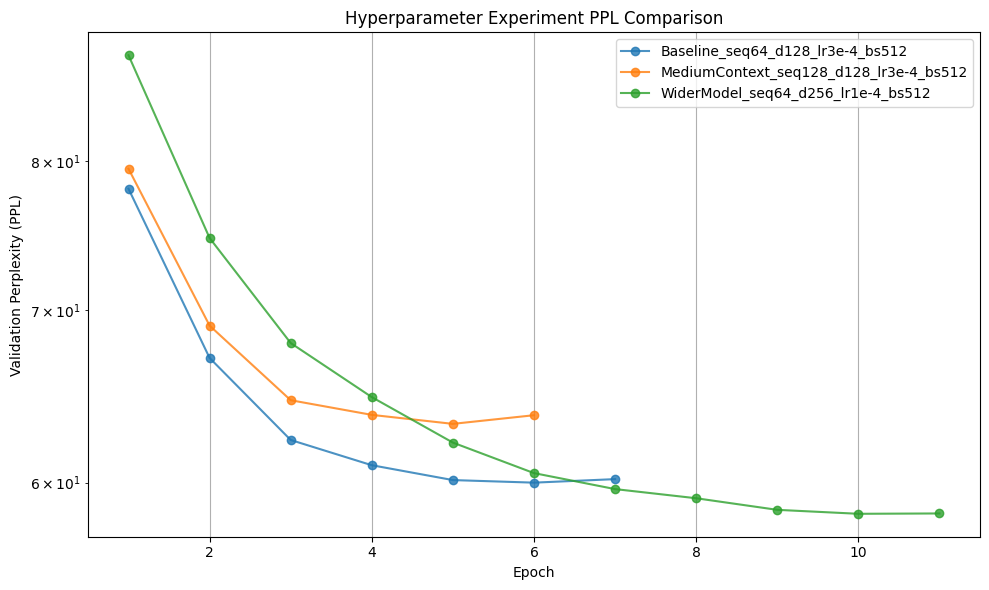

In [10]:
# ===================================================================
# 6a. AGGREGATE & DISPLAY ALL RESULTS
# ===================================================================
print("\n" + "="*80)
print("ALL EXPERIMENTS COMPLETE - FINAL RESULTS")
print("="*80)

best_ppl = float('inf')
best_result = None

for res in all_results:
    print(f"Config: {res['name']:25s} | Best PPL: {res['best_ppl']:.2f} (at Epoch {res['best_epoch']})")
    if res['best_ppl'] < best_ppl:
        best_ppl = res['best_ppl']
        best_result = res

print("\n" + "="*80)
print(f"🏆 BEST OVERALL MODEL: {best_result['name']} 🏆")
print(f"Best PPL: {best_result['best_ppl']:.2f}")
print("="*80)


# ===================================================================
# 6b. PLOT PPL COMPARISON
# ===================================================================
plt.figure(figsize=(10, 6))
for res in all_results:
    epochs = range(1, len(res['val_ppls_history']) + 1)
    plt.plot(epochs, res['val_ppls_history'], label=res['name'], marker='o', alpha=0.8)

plt.xlabel("Epoch")
plt.ylabel("Validation Perplexity (PPL)")
plt.title("Hyperparameter Experiment PPL Comparison")
plt.legend()
plt.grid(True)
plt.yscale("log")
plt.tight_layout()
plt.show()



--- Visualizing Best Model ---
Best model re-built and weights loaded.


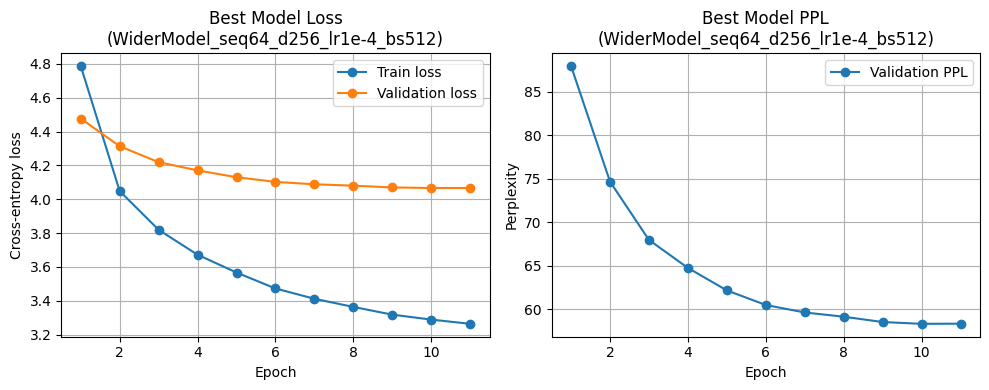

In [11]:
# ===================================================================
# 6c. RE-LOAD BEST MODEL FOR VISUALIZATION
# ===================================================================
print("\n--- Visualizing Best Model ---")
best_config = best_result['config']
best_model_state = best_result['best_model_state']
best_val_loader = best_result['val_loader']

best_model = TinyTransformerLM(
    vocab_size=vocab_size,
    d_model=best_config['d_model'],
    n_heads=best_config['n_heads'],
    d_ff=best_config['d_ff'],
    max_seq_len=best_config['seq_len'],
    n_layers=best_config['n_layers'],
).to(device)

best_model.load_state_dict(best_model_state)
print("Best model re-built and weights loaded.")

# ===================================================================
# 6d. PLOT BEST MODEL LOSS CURVES
# ===================================================================
epochs = np.arange(1, len(best_result['val_ppls_history']) + 1)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, best_result['train_loss_history'], marker="o", label="Train loss")
plt.plot(epochs, [math.log(p) for p in best_result['val_ppls_history']], marker="o", label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.title(f"Best Model Loss\n({best_result['name']})")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, best_result['val_ppls_history'], marker="o", label="Validation PPL")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title(f"Best Model PPL\n({best_result['name']})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Showing Attention Heatmap for Best Model: Layer 0, Head 0


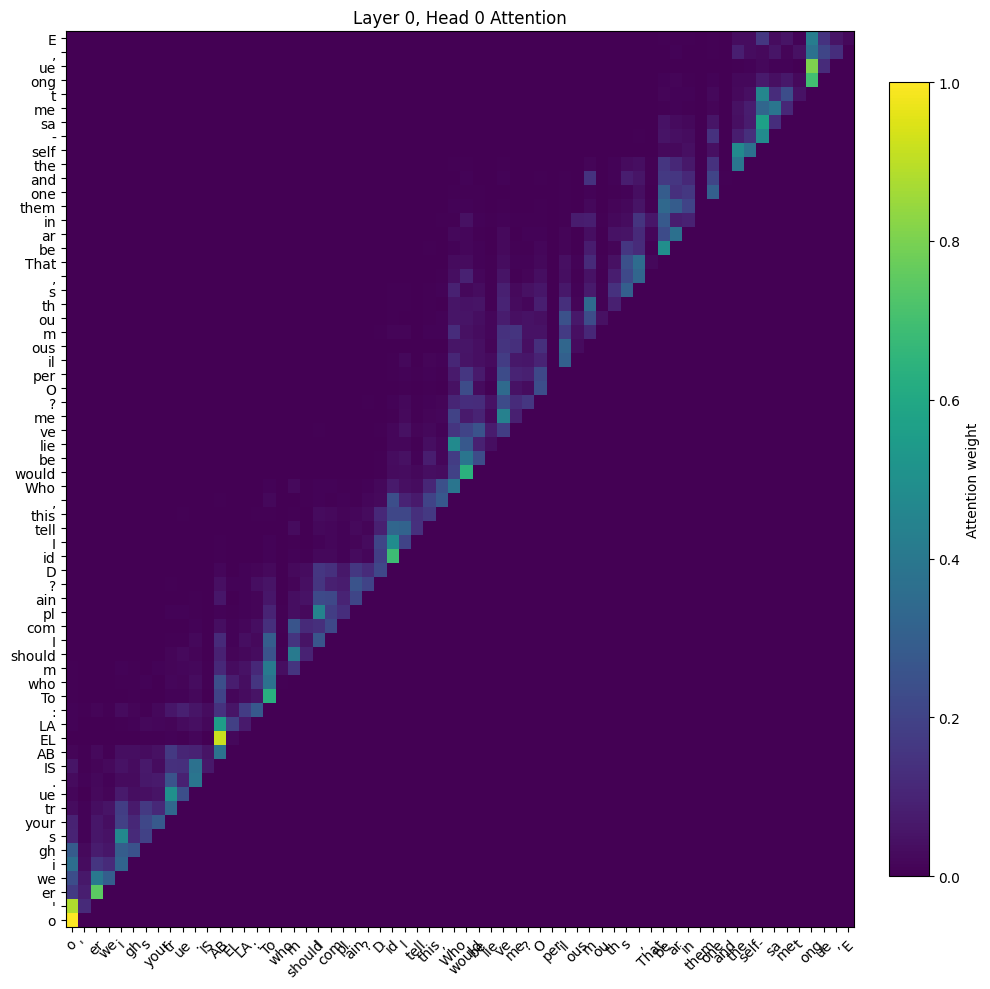

Showing Attention Heatmap for Best Model: Layer 0, Head 1


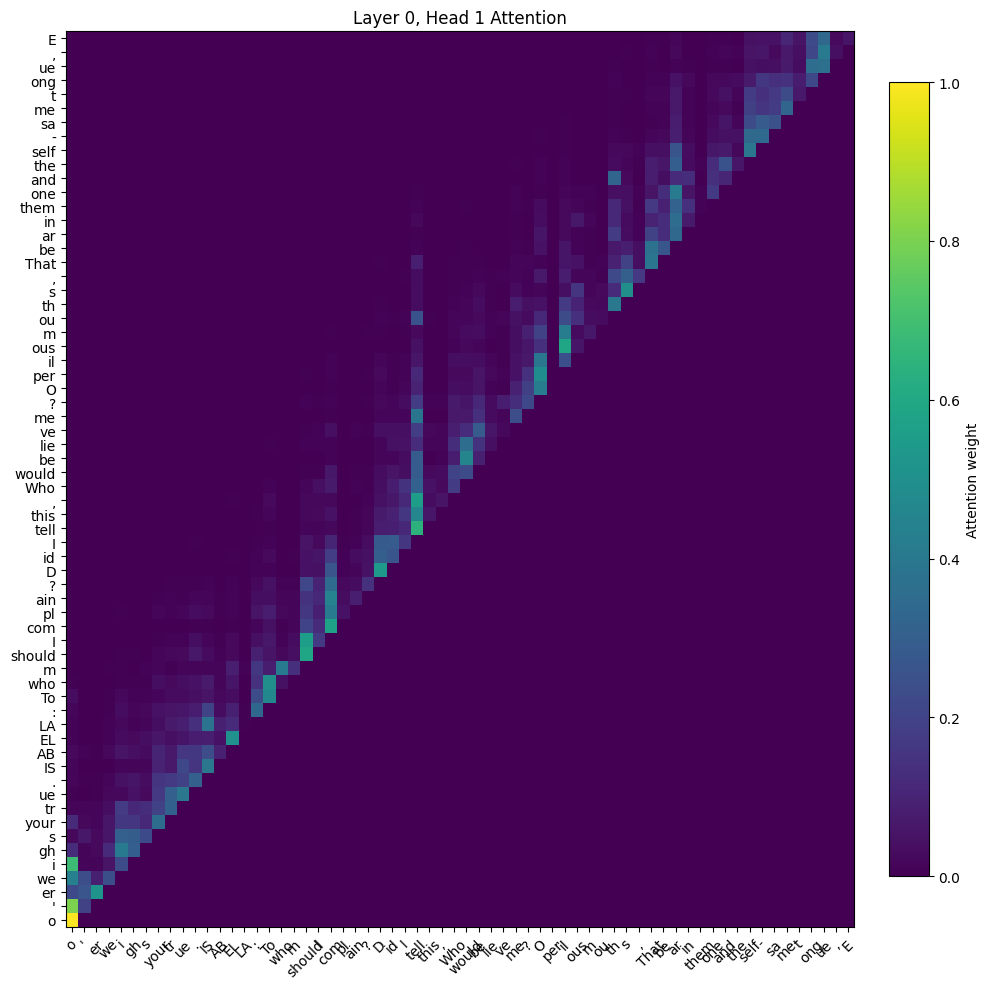

Showing Attention Heatmap for Best Model: Layer 1, Head 0


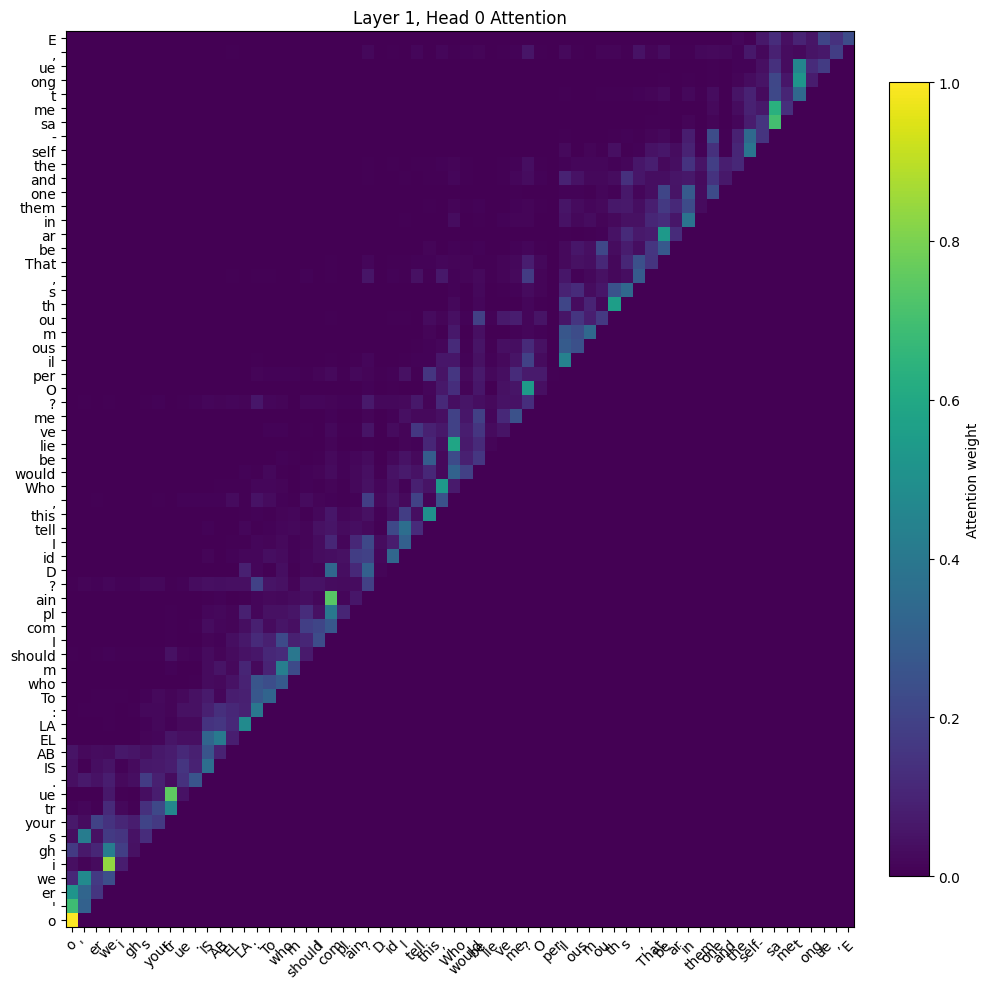

Showing Attention Heatmap for Best Model: Layer 1, Head 1


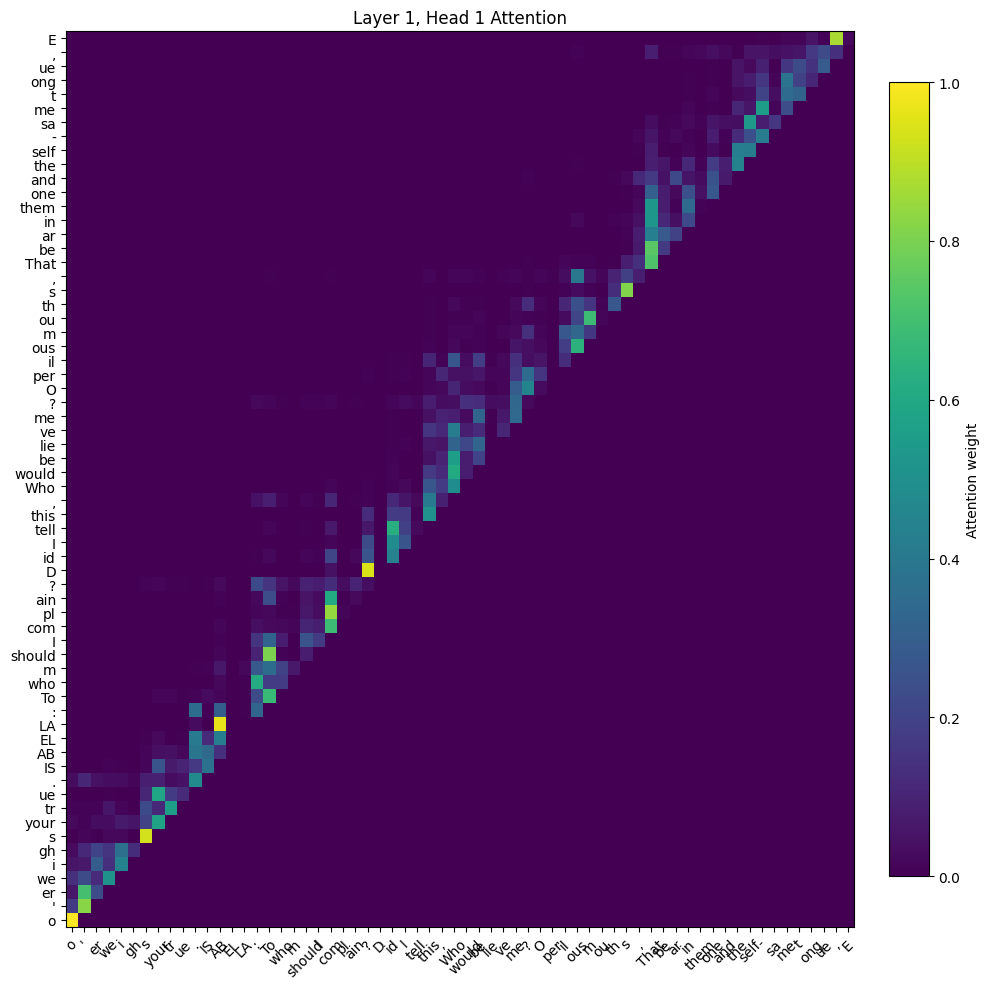


--- Best Model PPL Analysis ---
Epoch 1: val_ppl=87.97
Epoch 2: val_ppl=74.69
Epoch 3: val_ppl=67.99
Epoch 4: val_ppl=64.77
Epoch 5: val_ppl=62.19
Epoch 6: val_ppl=60.51
Epoch 7: val_ppl=59.65
Epoch 8: val_ppl=59.17
Epoch 9: val_ppl=58.56
Epoch 10: val_ppl=58.35
Epoch 11: val_ppl=58.37

Best validation perplexity: 58.35 at epoch 10


In [12]:
# ===================================================================
# 6e. PLOT BEST MODEL ATTENTION
# ===================================================================
n_layers = best_config['n_layers']
n_heads = best_config['n_heads']

for layer in range(n_layers):
    for head in range(min(n_heads, 2)): # Plot first 2 heads
        print(f"Showing Attention Heatmap for Best Model: Layer {layer}, Head {head}")
        # Pass the val_loader specific to this model
        show_attention_heatmap(best_model, tokenizer, best_val_loader, device, layer=layer, head=head)

# ===================================================================
# 6f. BEST MODEL PPL CONSOLE-LOG
# ===================================================================
print("\n--- Best Model PPL Analysis ---")
for epoch, ppl in enumerate(best_result['val_ppls_history'], start=1):
    print(f"Epoch {epoch}: val_ppl={ppl:.2f}")
print(f"\nBest validation perplexity: {best_result['best_ppl']:.2f} at epoch {best_result['best_epoch']}")

In [13]:
# ===================================================================
# 6g. INFERENCE: PREDICTED VS. ACTUAL
# ===================================================================
print("\n" + "---" * 20)
print(f"   INFERENCE USING BEST MODEL: {best_result['name']}")
print("---" * 20)

best_seq_len = best_config['seq_len']

print("\n--- PREDICTED vs. ACTUAL COMPARISON ---")

x_batch, y_batch = next(iter(best_val_loader))
sample_index = random.randint(0, x_batch.size(0) - 1)
actual_tensor = x_batch[sample_index]
actual_text = clean_generated(tokenizer.decode(actual_tensor.tolist()))

prompt_len = min(25, best_seq_len // 2)
prompt_tensor = actual_tensor[:prompt_len]
prompt_text = clean_generated(tokenizer.decode(prompt_tensor.tolist()))

predicted_text = generate_text(
    best_model,
    tokenizer,
    device,
    prompt=prompt_text,
    max_new_tokens=best_seq_len - prompt_len,
    seq_len=best_seq_len
)

print(f"\n[PROMPT USED (first {prompt_len} tokens)]:\n{prompt_text}")
print("-" * 60)
print(f"\n[ACTUAL TEXT (full {best_seq_len} tokens)]:\n{actual_text}")
print("-" * 60)
print(f"\n[PREDICTED TEXT (prompt + generated tokens)]:\n{predicted_text}")
print("---" * 20)

# ===================================================================
# 6h. INFERENCE: TOP-K PREDICTIONS
# ===================================================================
print("\n--- TOP-K NEXT TOKEN PREDICTIONS ---")

test_prompts = ["MENENIUS:", "BRUTUS:", "CORIOLANUS:"]
for prompt in test_prompts:
    preds = predict_next_tokens(best_model, tokenizer, device, prompt, seq_len=best_seq_len)
    print(f"\nPrompt: '{prompt}'")
    for i, (tok, p) in enumerate(preds, 1):
        bar = "█" * int(p * 40)
        print(f"  {i}. {tok:15s} {p:.3f} {bar}")


------------------------------------------------------------
   INFERENCE USING BEST MODEL: WiderModel_seq64_d256_lr1e-4_bs512
------------------------------------------------------------

--- PREDICTED vs. ACTUAL COMPARISON ---

[PROMPT USED (first 25 tokens)]:
er vi le to all the s k y ey in f l u en c es, That do st this ha b it
------------------------------------------------------------

[ACTUAL TEXT (full 64 tokens)]:
er vi le to all the s k y ey in f l u en c es, That do st this ha b it at ion, where thou ke ep'st, H our ly af f li ct: m ere ly, thou art death's f oo l; For him thou la b our'st
------------------------------------------------------------

[PREDICTED TEXT (prompt + generated tokens)]:
er vi le to all the s k y ey in f l u en c es, That do st this ha b it e as i de To take the w ant so. N OR T H UM B ER LAN D: S ome to his s le ave sp it to sha ke this: No more, he
------------------------------------------------------------

--- TOP-K NEXT TOKEN PREDICTIONS ---
